<a href="https://colab.research.google.com/github/RizalRio/py-occupancy-fuzzy/blob/main/OccupancyUAS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# FUZZY LOGIC FINAL: 4 INPUT (FULL SYSTEM)
# ==========================================

!pip install -U scikit-fuzzy

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 17.9 MB/s eta 0:00:00


✅ System Loaded: Advanced Rules Logic Ready...

🏢 Analisis Detail (10 Rules):
   - Cahaya    : 426 Lux
   - CO2       : 721 ppm
   - Suhu      : 23.18 C
   - Humidity  : 27 %

🚀 Skor Akhir: 57.38 / 100


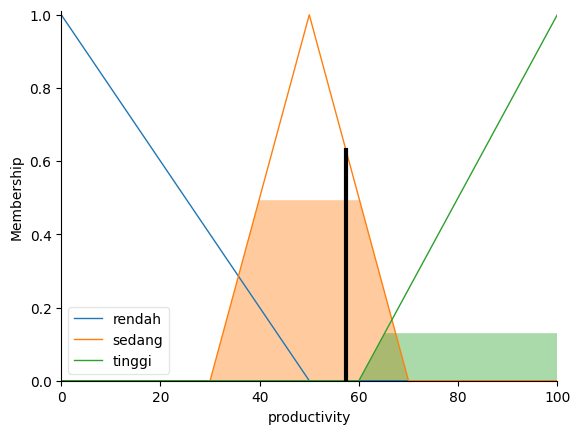

KESIMPULAN: Ruangan Standar (Medium Productivity). Cukup oke buat kerja rutin. ✅


In [ ]:
print("✅ System Loaded: Advanced Rules Logic Ready...")

# ==========================================
# 1. VARIABEL INPUT (Versi Tuned/Relaxed)
# ==========================================
light = ctrl.Antecedent(np.arange(0, 1001, 1), 'light')
co2   = ctrl.Antecedent(np.arange(0, 2001, 1), 'co2')
temp  = ctrl.Antecedent(np.arange(15, 36, 1), 'temp')
humid = ctrl.Antecedent(np.arange(0, 101, 1), 'humid')
productivity = ctrl.Consequent(np.arange(0, 101, 1), 'productivity')

# --- MEMBERSHIP FUNCTIONS (Versi Pemaaf) ---

# CAHAYA
light['kurang'] = fuzz.trimf(light.universe, [0, 0, 300])
light['cukup']  = fuzz.trimf(light.universe, [200, 350, 500])
light['ideal']  = fuzz.trapmf(light.universe, [400, 600, 1000, 1000])

# CO2
co2['segar']  = fuzz.trimf(co2.universe, [0, 0, 600])
co2['biasa']  = fuzz.trimf(co2.universe, [500, 800, 1100])
co2['pengap'] = fuzz.trapmf(co2.universe, [900, 1200, 2000, 2000])

# SUHU
temp['dingin'] = fuzz.trimf(temp.universe, [15, 15, 21])
temp['nyaman'] = fuzz.trimf(temp.universe, [20, 24, 28])
temp['panas']  = fuzz.trapmf(temp.universe, [26, 30, 35, 35])

# HUMIDITY
humid['kering'] = fuzz.trimf(humid.universe, [0, 0, 25])
humid['ideal']  = fuzz.trimf(humid.universe, [20, 50, 75])
humid['lembab'] = fuzz.trapmf(humid.universe, [70, 85, 100, 100])

# OUTPUT (PRODUKTIVITAS)
productivity['rendah'] = fuzz.trimf(productivity.universe, [0, 0, 50])
productivity['sedang'] = fuzz.trimf(productivity.universe, [30, 50, 70])
productivity['tinggi'] = fuzz.trimf(productivity.universe, [60, 100, 100])


# ==========================================
# 2. ADVANCED RULE BASE (10 RULES) 🧠
# ==========================================

# --- KELOMPOK 1: DEAL BREAKERS (Kondisi Parah -> Rendah) ---
# R1: Panas banget = Bubar
rule1 = ctrl.Rule(temp['panas'], productivity['rendah'])
# R2: Pengap banget (CO2 tinggi) = Ngantuk/Pusing
rule2 = ctrl.Rule(co2['pengap'], productivity['rendah'])
# R3: Gelap = Gak kelihatan kerjaan
rule3 = ctrl.Rule(light['kurang'], productivity['rendah'])
# R4: Gak nyaman secara fisik (Terlalu Kering ATAU Terlalu Lembab)
rule4 = ctrl.Rule(humid['kering'] | humid['lembab'], productivity['rendah'])

# --- KELOMPOK 2: KOMPROMI / SITUASI UMUM (Campuran -> Sedang) ---
# R5: Suhu nyaman TAPI Cahaya cuma 'Cukup' (Bukan ideal) -> Sedang
rule5 = ctrl.Rule(temp['nyaman'] & light['cukup'], productivity['sedang'])
# R6: Cahaya Ideal TAPI Udara biasa aja (Agak rame) -> Sedang
rule6 = ctrl.Rule(light['ideal'] & co2['biasa'], productivity['sedang'])
# R7: Suhu agak dingin (AC kenceng) TAPI Udara Segar -> Sedang (Masih oke buat mikir)
rule7 = ctrl.Rule(temp['dingin'] & co2['segar'], productivity['sedang'])

# --- KELOMPOK 3: GOLD STANDARD (Sempurna -> Tinggi) ---
# R8: The Perfect Flow (Cahaya Ideal + Suhu Nyaman)
rule8 = ctrl.Rule(light['ideal'] & temp['nyaman'], productivity['tinggi'])
# R9: Healthy Workspace (Udara Segar + Humidity Ideal)
rule9 = ctrl.Rule(co2['segar'] & humid['ideal'], productivity['tinggi'])
# R10: ULTIMATE PERFECTION (Semua kondisi terpenuhi)
rule10 = ctrl.Rule(
    light['ideal'] & co2['segar'] & temp['nyaman'] & humid['ideal'],
    productivity['tinggi']
)

# Build System dengan 10 Rules
prod_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4,
    rule5, rule6, rule7,
    rule8, rule9, rule10
])
analyze_prod = ctrl.ControlSystemSimulation(prod_ctrl)


# ==========================================
# 3. SIMULASI FINAL
# ==========================================
# Mari kita tes dengan data kamu yang tadi (yang hasilnya 23 rendah banget)
# Harusnya sekarang naik karena definisi humidity sudah kita perbaiki (tuned)

input_light = 426
input_co2   = 721
input_temp  = 23.18
input_humid = 27

print(f"\n🏢 Analisis Detail (10 Rules):")
print(f"   - Cahaya    : {input_light} Lux")
print(f"   - CO2       : {input_co2} ppm")
print(f"   - Suhu      : {input_temp} C")
print(f"   - Humidity  : {input_humid} %")

analyze_prod.input['light'] = input_light
analyze_prod.input['co2']   = input_co2
analyze_prod.input['temp']  = input_temp
analyze_prod.input['humid'] = input_humid

# Compute
analyze_prod.compute()
skor = analyze_prod.output['productivity']

print(f"\n🚀 Skor Akhir: {skor:.2f} / 100")

# Visualisasi Grafik Output
productivity.view(sim=analyze_prod)
plt.show()

# Kesimpulan Detail
if skor < 40:
    print("KESIMPULAN: Ruangan Tidak Nyaman (Low Productivity). Perbaiki AC/Ventilasi! ⚠️")
elif skor < 75:
    print("KESIMPULAN: Ruangan Standar (Medium Productivity). Cukup oke buat kerja rutin. ✅")
else:
    print("KESIMPULAN: Ruangan Perfect (High Productivity). Ide bakal ngalir deras! 🔥")

⏳ Sedang me-render grafik 3D... (Sekarang lebih aman)


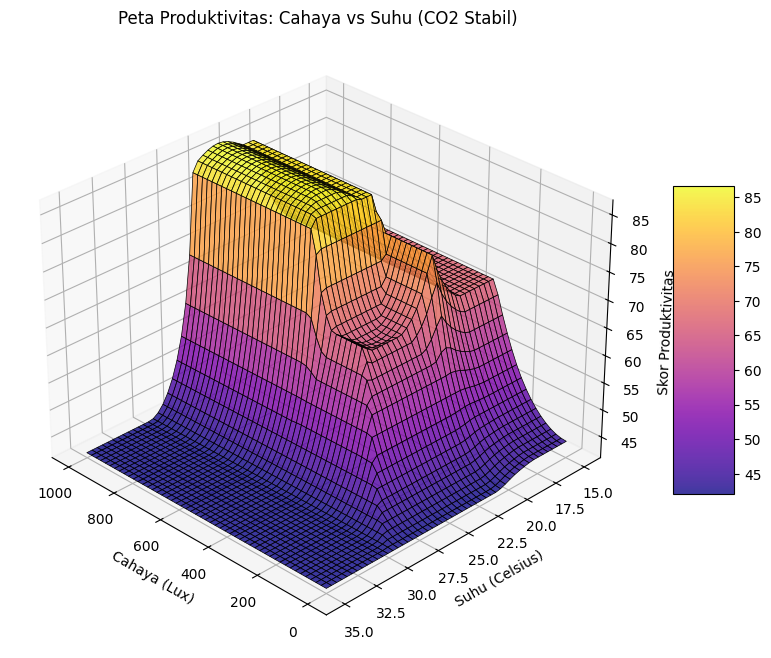

In [ ]:
# ==========================================
# VISUALISASI 3D (REVISI ANTI-ERROR) 🛡️
# ==========================================
from mpl_toolkits.mplot3d import Axes3D

# 1. Bikin range data
upsampled = np.linspace(0, 1001, 50) # Cahaya
x_temp = np.linspace(15, 35, 50)     # Suhu

x, y = np.meshgrid(upsampled, x_temp)
z = np.zeros_like(x)

print("⏳ Sedang me-render grafik 3D... (Sekarang lebih aman)")

# 2. Loop Kalkulasi dengan Safety Net
for i in range(50):
    for j in range(50):
        # Input Variabel yang berubah (Sumbu X dan Y)
        analyze_prod.input['light'] = x[i, j]
        analyze_prod.input['temp']  = y[i, j]

        # Input Variabel Statis (KITA UBAH BIAR AMAN)
        analyze_prod.input['co2']   = 300  # Ubah ke 300 biar masuk kategori 'Segar'
        analyze_prod.input['humid'] = 45   # 45% itu Ideal

        # Coba hitung, kalau error (karena rule gak ada yg kena), isi 0
        try:
            analyze_prod.compute()
            z[i, j] = analyze_prod.output['productivity']
        except:
            z[i, j] = 0.0  # Default value kalau sistem bingung

# 3. Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Kita warnai biar cantik (cmap='viridis' atau 'plasma')
surf = ax.plot_surface(x, y, z, cmap='plasma', linewidth=0.5, edgecolors='k', alpha=0.8)

ax.set_xlabel('Cahaya (Lux)')
ax.set_ylabel('Suhu (Celsius)')
ax.set_zlabel('Skor Produktivitas')
ax.set_title('Peta Produktivitas: Cahaya vs Suhu (CO2 Stabil)')
ax.view_init(elev=30, azim=135)

plt.colorbar(surf, shrink=0.5, aspect=5)
plt.show()